In [2]:
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from cycler import cycler

In [3]:
time_format = '%d-%m %H:%M:%S'
def read_single_dstat(inputdir, rep, dstat_filename, truncate_sec):
    # create filepath
    filepath = os.path.join(inputdir, str(rep), dstat_filename)
    csv_file = pd.read_csv(filepath, header=3)
    
    start_time = csv_file['time'].min()
    end_time = csv_file['time'].max()
    parsed_start_time = datetime.datetime.strptime(start_time, time_format)
    parsed_end_time = datetime.datetime.strptime(end_time, time_format)
    truncated_start_time = parsed_start_time + datetime.timedelta(0,truncate_sec)
    truncated_end_time = parsed_end_time - datetime.timedelta(0,truncate_sec)
    truncated_start_string = truncated_start_time.strftime(time_format)
    truncated_end_string = truncated_end_time.strftime(time_format)
    
    truncated_data = csv_file[(csv_file['time'] >= truncated_start_string) & (csv_file['time'] <= truncated_end_string)]
    
    excerp = truncated_data.loc[:, ['idl', 'recv', 'send']]
    means = excerp.mean()
    means['load'] = 100 - means['idl']
    
    return means

In [4]:
def read_dstat_all_reps(inputdir, reps, dstat_filename, truncate_sec):
    all_reps = [read_single_dstat(inputdir, rep, dstat_filename, truncate_sec) for rep in range(1, reps+1)]
    result = pd.concat(all_reps, axis='columns').mean(axis='columns')
    return result

In [5]:
def read_dstat_all_clients(inputdir, reps, dstat_filenames, truncate_sec):
    all_clients = [read_dstat_all_reps(inputdir, reps, filename, truncate_sec) for filename in dstat_filenames]
    result = pd.concat(all_clients, axis='columns')
    return result

In [6]:
def mean_dstat_clients(data, mean_columns):
    return data.loc[mean_columns, :].mean(axis='columns')

def sum_dstat_clients(data, sum_columns):
    return data.loc[sum_columns, :].sum(axis='columns')

def aggregate_dstat_all_clients(inputdir, reps, dstat_filenames, truncate_sec):
    data = read_dstat_all_clients(inputdir, reps, dstat_filenames, truncate_sec)
    means = mean_dstat_clients(data, ['load'])
    sums = sum_dstat_clients(data, ['recv', 'send'])
    return pd.concat([means, sums])

In [7]:
experiment_dir = "/home/flo/Documents/eth-asl-final-experiment-data/exp2/2_1_baseline_oneserver_2017-11-16_080053"
workloads = ["readOnly", "writeOnly"]
vcs = [1, 4, 8, 16, 32, 64, 128, 256]
dstat_filenames = ["client_dstat_01.log", "client_dstat_02.log", "client_dstat_03.log"]
reps = 3
truncate_sec = 0
num_threads = 6

all_metrics = []
for vc in vcs:
    for wl in workloads:
        inputdir = os.path.join(experiment_dir, "{}_{}vc".format(wl, vc))
        metrics = aggregate_dstat_all_clients(inputdir, reps, dstat_filenames, truncate_sec)
        metrics['num_clients'] = vc * num_threads
        metrics['workload'] = wl
        all_metrics.append(metrics)
nice_table = pd.concat(all_metrics, axis=1).transpose()
nice_table['recv'] = nice_table['recv'] / 1000000
nice_table['send'] = nice_table['send'] / 1000000
print("Done")

Done


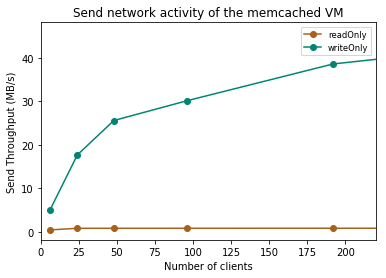

In [15]:
fig, ax = plt.subplots()
#ax.set_ylim([0, 30])
ax.set_xlim([0, 220])
ax.set_prop_cycle(cycler('color',['#a6611a', '#018571']))
for key, grp in nice_table.groupby(['workload']):
    grp.plot(ax=ax, x='num_clients', y='send', label=key, marker='o')
    #plt.xticks(grp['num_clients'])
ax.legend(loc="best", fontsize="small")
ax.set_title("Send network activity of the memcached VM")
ax.set_xlabel("Number of clients")
ax.set_ylabel("Send Throughput (MB/s)")

plt.show()